# Imports

In [1]:
%load_ext autoreload
% autoreload 2

UsageError: Line magic function `%` not found.


In [2]:
import argparse
import datetime
import numpy as np
import time
import torch
import torch.backends.cudnn as cudnn
import json
import os
from contextlib import suppress
import random

from pathlib import Path
from collections import OrderedDict

from ema import ModelEma
from optim_factory import create_optimizer, get_parameter_groups, LayerDecayValueAssigner

import utils
from utils import NativeScalerWithGradNormCount as NativeScaler

from build_dataset import build_dataset
from engine_self_training import train_one_epoch, evaluate, evaluate_with_clip

from model import clip_classifier

import warnings
warnings.filterwarnings("ignore")

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from torchvision import transforms

/cs/labs/yedid/jonkahana/lord_cl_venv/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


# Args

In [3]:
model_type = 'ViT-B/16'
dataset = 'imagenet'
chosen_epoch = 'best'

def get_args():
    parser = argparse.ArgumentParser('MUST training and evaluation script', add_help=False)
    parser.add_argument('--batch_size', default=64, type=int)
    parser.add_argument('--save_ckpt_freq', default=10, type=int)
    parser.add_argument('--eval_freq', default=1, type=int)

    # CLIP parameters
    parser.add_argument("--template", default='templates.json', type=str)
    parser.add_argument("--classname", default='classes.json', type=str)
#     parser.add_argument('--clip_model', default='ViT-B/16', help='pretrained clip model name')
    parser.add_argument('--image_mean', default=(0.48145466, 0.4578275, 0.40821073))
    parser.add_argument('--image_std', default=(0.26862954, 0.26130258, 0.27577711))
    parser.add_argument('--input_size', default=224, type=int, help='images input size')

    # training parameters
    parser.add_argument("--train_config", default='train_configs.json', type=str, help='training configurations')
    parser.add_argument('--mask', action='store_true')
    parser.set_defaults(mask=True)
    parser.add_argument('--model_ema_decay', type=float, default=0.9998, help='')
    parser.add_argument('--model_ema_force_cpu', action='store_true', default=False, help='')

    # Optimizer parameters
    parser.add_argument('--opt', default='adamw', type=str, metavar='OPTIMIZER',
                        help='Optimizer (default: "adamw"')
    parser.add_argument('--opt_eps', default=1e-8, type=float, metavar='EPSILON',
                        help='Optimizer Epsilon (default: 1e-8)')
    parser.add_argument('--opt_betas', default=None, type=float, nargs='+', metavar='BETA',
                        help='Optimizer Betas (default: None, use opt default)')
    parser.add_argument('--weight_decay', type=float, default=0.05,
                        help='weight decay (default: 0.05)')
    parser.add_argument('--lr', type=float, default=1e-3, metavar='LR',
                        help='learning rate (default: 1e-3)')
    parser.add_argument('--layer_decay', type=float, default=0.65)
    parser.add_argument('--warmup_lr', type=float, default=1e-6, metavar='LR',
                        help='warmup learning rate (default: 1e-6)')
    parser.add_argument('--min_lr', type=float, default=1e-6, metavar='LR',
                        help='lower lr bound for cyclic schedulers that hit 0')
    parser.add_argument('--warmup_epochs', type=int, default=0, metavar='N',
                        help='epochs to warmup LR, if scheduler supports')
    parser.add_argument('--warmup_steps', type=int, default=-1, metavar='N',
                        help='num of steps to warmup LR, will overload warmup_epochs if set > 0')

    # Augmentation parameters
    parser.add_argument('--train_crop_min', default=0.3, type=float)
    parser.add_argument('--color_jitter', type=float, default=0, metavar='PCT')
    parser.add_argument('--aa', type=str, default='rand-m9-mstd0.5-inc1', metavar='NAME',
                        help='Use AutoAugment policy. "v0" or "original". " + "(default: rand-m9-mstd0.5-inc1)'),
    parser.add_argument('--train_interpolation', type=str, default='bicubic',
                        help='Training interpolation (random, bilinear, bicubic default: "bicubic")')

    # Dataset parameters
    parser.add_argument('--nb_classes', default=0, type=int, help='number of the classification types')
#     parser.add_argument('--dataset', default='imagenet', type=str, help='dataset name')

    parser.add_argument('--output_dir', default='', help='path to save checkpoint and log')
    parser.add_argument('--device', default='cuda',
                        help='device to use for training / testing')
    parser.add_argument('--seed', default=0, type=int)
    parser.add_argument('--resume', default='',
                        help='resume from checkpoint')
    parser.add_argument('--auto_resume', action='store_true')
    parser.set_defaults(auto_resume=True)

    parser.add_argument('--start_epoch', default=0, type=int, metavar='N',
                        help='start epoch')
    parser.add_argument('--eval', action='store_true',
                        help='Perform evaluation only')
    parser.add_argument('--num_workers', default=10, type=int)

    # distributed training parameters
    parser.add_argument('--world_size', default=1, type=int,
                        help='number of distributed processes')
    parser.add_argument('--local_rank', default=-1, type=int)
    parser.add_argument('--dist_on_itp', action='store_true')
    parser.add_argument('--dist_url', default='env://',
                        help='url used to set up distributed training')
    parser.add_argument('--amp', action='store_true')

    return parser.parse_args('')

In [4]:
args = get_args()
args.clip_model  = model_type
args.dataset = dataset
args.load_epoch = chosen_epoch

# Init Scripts

In [5]:
utils.init_distributed_mode(args)
train_configs = json.load(open(args.train_config,'r'))
train_config = train_configs[args.dataset+'_'+args.clip_model]

if not args.output_dir:
    args.output_dir = os.path.join('output',args.dataset)
    if args.mask:
        args.output_dir = os.path.join(args.output_dir, "%s_mpatch%d_mratio%.1f_walign%.1f_tau%.1f_epoch%d_lr%.5f"%(args.clip_model[:5],train_config['mask_patch_size'],train_config['mask_ratio'],train_config['w_align'],train_config['conf_threshold'],train_config['epochs'], train_config['lr']))
    else:
        args.output_dir = os.path.join(args.output_dir, "%s_tau%.1f_epoch%d_lr%.5f"%(args.clip_model[:5],train_config['conf_threshold'],train_config['epochs'], train_config['lr']))
        
device = torch.device(args.device)

# fix the seed for reproducibility
seed = args.seed + utils.get_rank()
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

cudnn.benchmark = True

Not using distributed mode


# Init Model + Dataset

## Model

In [6]:
# create image classifier from pretrained clip model
model = clip_classifier(args)
clip = clip_classifier(args)
args.nb_classes = len(model.classnames)
if args.load_epoch is not None:
    checkpoint_path = os.path.join(args.output_dir, f'checkpoint-{args.load_epoch}.pth')
    model.load_state_dict(torch.load(checkpoint_path)['model'])

missing keys:
['visual.mask_token_embedding', 'visual.ln_patch.weight', 'visual.ln_patch.bias', 'visual.decoder.0.weight', 'visual.decoder.0.bias']
1000 classes, 80 templates


100%|██████████| 1000/1000 [00:52<00:00, 18.93it/s]


missing keys:
['visual.mask_token_embedding', 'visual.ln_patch.weight', 'visual.ln_patch.bias', 'visual.decoder.0.weight', 'visual.decoder.0.bias']
1000 classes, 80 templates


100%|██████████| 1000/1000 [00:51<00:00, 19.35it/s]


## DataSet

In [ ]:
dataset_train = build_dataset(is_train=True, args=args, train_config=train_config)
dataset_val = build_dataset(is_train=False, args=args)


sampler_train = torch.utils.data.RandomSampler(dataset_train)
sampler_val = torch.utils.data.SequentialSampler(dataset_val)


data_loader_train = torch.utils.data.DataLoader(
    dataset_train, sampler=sampler_train,
    batch_size=args.batch_size,
    num_workers=args.num_workers,
    pin_memory=True,
    drop_last=True,
)

data_loader_val = torch.utils.data.DataLoader(
    dataset_val, sampler=sampler_val,
    batch_size=2*args.batch_size,
    num_workers=args.num_workers,
    pin_memory=True,
    drop_last=False
)

data_loader_vis = torch.utils.data.DataLoader(
    dataset_val,
    batch_size=2*args.batch_size,
    num_workers=args.num_workers,
    pin_memory=True,
    shuffle=True,
    drop_last=False
)

Transform = 
 - - - - - - - - - - 
Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
RandomCrop(size=(224, 224), padding=None)
ToTensor()
Normalize(mean=tensor([0.4815, 0.4578, 0.4082]), std=tensor([0.2686, 0.2613, 0.2758]))
 - - - - - - - - - - 
RandomResizedCropAndInterpolation(size=(224, 224), scale=(0.3, 1), ratio=(0.75, 1.3333), interpolation=bicubic)
RandomHorizontalFlip(p=0.5)
RandAugment(n=2, ops=
	AugmentOp(name=AutoContrast, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Equalize, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Invert, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Rotate, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=PosterizeIncreasing, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=SolarizeIncreasing, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=SolarizeAdd, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=ColorIncreasing, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=ContrastIncreasing, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=BrightnessIncreasing, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=SharpnessIncreasing, 

# Eval Stats

In [14]:
with torch.no_grad():
    test_stats = evaluate_with_clip(data_loader_val, model, device, clip=clip, args=args)
    print(f"Accuracy of the network on the {len(dataset_val)} test images: {test_stats['acc1']:.1f}%")

Test:  [ 0/30]  eta: 0:01:44  acc1: 93.7500 (93.7500)  ema_acc1: 84.3750 (84.3750)  model_vs_ema_acc1: 85.1562 (85.1562)  model_vs_ema_acc1_on_wrongs: 50.0000 (50.0000)  time: 3.4775  data: 2.8556  max mem: 2015
Test:  [10/30]  eta: 0:00:17  acc1: 72.1591 (72.1591)  ema_acc1: 70.3125 (70.3125)  model_vs_ema_acc1: 74.5028 (74.5028)  model_vs_ema_acc1_on_wrongs: 41.0491 (45.9184)  time: 0.8899  data: 0.2598  max mem: 2015
Test:  [20/30]  eta: 0:00:07  acc1: 69.3750 (70.5357)  ema_acc1: 65.7422 (66.6295)  model_vs_ema_acc1: 74.2578 (74.7768)  model_vs_ema_acc1_on_wrongs: 46.9287 (49.4949)  time: 0.6305  data: 0.0002  max mem: 2015
Test:  [29/30]  eta: 0:00:00  acc1: 73.0821 (73.8567)  ema_acc1: 67.1688 (68.9136)  model_vs_ema_acc1: 77.0676 (76.5001)  model_vs_ema_acc1_on_wrongs: 51.4501 (49.2417)  time: 0.6174  data: 0.0001  max mem: 2015
Test: Total time: 0:00:21 (0.7219 s / it)
* Acc@1 73.857
* CLIP Acc@1 68.914
\% Same answer as CLIP 76.500
\% Same answer as CLIP in Mistakes 49.242
Acc

# Visual Evaluation

In [74]:
model.eval()

p=np.random.uniform()
with torch.no_grad():
    for batch in data_loader_vis:
        if np.random.uniform() > p:
            
            images = batch[0].to(device, non_blocking=True)
            target = batch[-1].to(device, non_blocking=True)

            # compute output
            output = model(images)
            clip_output = clip(images)
            break
        
        
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])
images = invTrans(images)
images = images.detach().cpu().numpy()
images *= 255.
images = images.astype(int).transpose(0, 2, 3, 1)
target = target.detach().cpu().numpy()
output = output.detach().cpu().numpy()
clip_output = clip_output.detach().cpu().numpy()
classnames = np.array(model.classnames)
target_names = classnames[target]
preds = output.argmax(axis=1)
preds_names = classnames[preds]
clip_preds = clip_output.argmax(axis=1)
clip_preds_names = classnames[clip_preds]


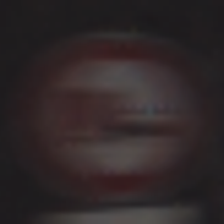
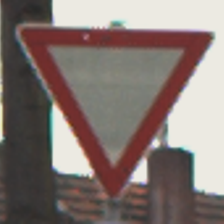
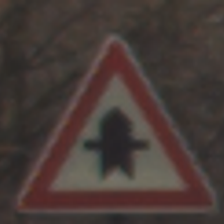
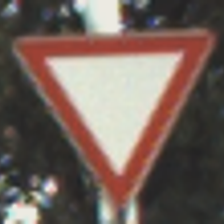
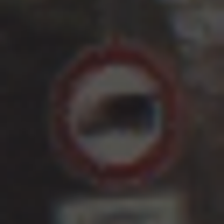
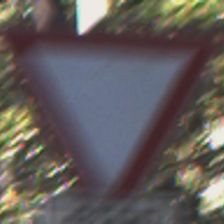
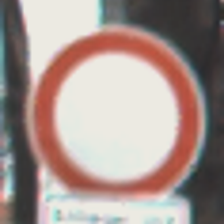

In [77]:
num_imgs = 7
wrong_indxs = np.where(target != preds)[0]
rand_indxs = np.random.choice(wrong_indxs, 
                              size=num_imgs, replace=False)
sub_titles = [f'T: {t}<br>P: {p}<br>Clip: {c}' for p,t, c in 
              zip(preds_names[rand_indxs], 
                  target_names[rand_indxs], clip_preds_names[rand_indxs])]
fig = make_subplots(rows=1, cols=num_imgs, 
                    shared_xaxes=True, shared_yaxes=True,
#                     subplot_titles=sub_titles
                   )
for j, i in enumerate(rand_indxs):
    color = 'Blue' if target[i] == preds[i] else 'Red'
    fig.add_trace(px.imshow(images[i]/255., labels={'f':sub_titles[j]}).data[0], row=1, col=j+1)
    fig.add_trace(go.Scatter(x=[20], y=[20], marker=dict(color=color, size=10), hovertext=[sub_titles[j]]), row=1, col=j+1)
    
fig.update_layout(width=1000, height=400)
fig.show()
